In [1]:
#import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

# Airplanes

- Data import
- Data inspection and cleaning
- Visualisation

## Data import

Import as pandas `dataframe` the weather report and the flights data.

In [2]:
flights_name = "../data/flights_small.csv"
# flights_name = "../data/flights_medium.csv"
# flights_name = "../data/flights_large.csv"
flights = pd.read_csv(flights_name)

In [3]:
weather_name = "../data/weather.csv"
weather = pd.read_csv(weather_name)

## Data inspection, cleaning, and augmentation

Inspect `flights` `dataframe` columns content.

In [4]:
flights.head()

,Date,Airline,Airline_code,Arrival_airport,Arrival_state,Departure_Airport,Departure_State,Departure_actual,Departure_delay,Arrival_actual,Arrival_delay,Arrival_schedule,Departure_schedule,DC_Longitude,DC_Latitude,Longitude,Latitude,Route,Path_order
0,2003-04-05,EV,20366,SHV,LA,MOB,AL,1820,-10,2048,30,2018,1830,-88.24,30.69,-88.24,30.69,AL to LA,1
1,2006-04-10,YV,20378,CLT,NC,MGM,AL,1613,-10,1833,-9,1842,1623,-86.39,32.30,-86.39,32.30,AL to NC,1
2,2006-04-05,YV,20378,CLT,NC,MGM,AL,1615,-8,1825,-17,1842,1623,-86.39,32.30,-86.39,32.30,AL to NC,1
3,2006-01-12,YV,20378,CLT,NC,MGM,AL,1620,-3,1840,1,1839,1623,-86.39,32.30,-86.39,32.30,AL to NC,1
4,2006-01-05,YV,20378,CLT,NC,MGM,AL,1614,0,1840,10,1830,1614,-86.39,32.30,-86.39,32.30,AL to NC,1


The `flights` `dataframe` has 19 columns containing information on the flight date (`YYYY-MM-DD` format), operating airline (both with a two character _string_ code and a five digits _integer_ code), departure and arrival airport codes (two characters _string_), departure and arrival state codes (two characters _string_), actual and scheduled departure time (24h _integer_ format), time delay at departure in minutes (_signed integer_; this is also calculated as `Departure_actual - Departure_schedule`, therefore a negative departure time indicates that the ariplane took off before than expected), scheduled and actual arrival time (24h _integer_ format), arrival delay (_signed integer_; this can be also be calculated as `Arrival_actual - Arrival_schedule`), longitude and latitude of the departure airport (_signed float_; there are two pairs of column with this kind of data), route (_string_ departure/arrival airport codes), and the path order (_integer_).

Inspect `weather` `dataframe` content.

In [5]:
weather.head()

,Date,airport,time,temperature,snow,wind
0,2006-03-14,ORD,2041,35,NaN,18.6
1,2006-09-08,SLC,807,72,NaN,6.5
2,2006-10-22,MCO,1202,81,0.0,3.1
3,2006-10-22,MCO,602,81,0.0,3.1
4,2007-07-09,MRY,1011,64,NaN,0.7


There are 35M+ rows and 6 columns containing the weather report date (`YYYY-MM-DD` format), airport code (_string_), time of the day (24h _integer_ format), temperature (Farenheit degrees as _signed integer_), snow inches (_float_ or `NaN`), and wind velocity magnitude (_float_).

### Cleaning
Replace `NaN`s in the `snow` cloumn with zeroes. We assume that if there are not information about the snow, this is because there was not snow at all.

In [6]:
weather["snow"].fillna(0.0, inplace=True)

Remove from `weather` all the rows referring to airports and dates not in `flights`.

In [7]:
airports = list(set(list(set(flights["Departure_Airport"])) + list(set(flights["Arrival_airport"]))))
weather = weather[weather["Date"].isin(flights["Date"]) & (weather["airport"].isin(airports))]

Convert date and time to `datetime` format

In [8]:
weather["Date"] = pd.to_datetime(weather["Date"])
flights["Date"] = pd.to_datetime(flights["Date"])

Fix `weather` header (we'll use only the departure airport weather to train the delay classifier).

In [9]:
weather.columns = ['Date','Departure_Airport','Departure_schedule', 'Temperature','Snow','Wind']

Convert time in `flights` as well.

Merge `weather` and `flights` on the departure time, date, and location columns.

In [11]:
flights = pd.merge(flights, weather, on=['Date', 'Departure_Airport', 'Departure_schedule'], how='left')

### Augmentation

Add `year`, `month`, and `day` columns to ease the plotting process.

In [12]:
flights["year"] = flights["Date"].dt.year
flights["month"] = flights["Date"].dt.month
flights["day"] = flights["Date"].dt.day

Use mean values across months to fill in the weather information missing. Here the assumption is that the weather is similar in the same month of the year for a specific location.

In [13]:
flights["Temperature"] = flights.groupby(["month", "Departure_Airport"])["Temperature"].transform(lambda x: x.fillna(x.mean()))
flights["Temperature"] = flights.groupby(["month", "Departure_State"])["Temperature"].transform(lambda x: x.fillna(x.mean()))
flights["Temperature"] = flights.groupby(["month"])["Temperature"].transform(lambda x: x.fillna(x.mean()))

flights["Wind"] = flights.groupby(["month", "Departure_Airport"])["Wind"].transform(lambda x: x.fillna(x.mean()))
flights["Wind"] = flights.groupby(["month", "Departure_State"])["Wind"].transform(lambda x: x.fillna(x.mean()))
flights["Wind"] = flights.groupby(["month"])["Wind"].transform(lambda x: x.fillna(x.mean()))

flights["Snow"] = flights.groupby(["month", "Departure_Airport"])["Snow"].transform(lambda x: x.fillna(x.mean()))
flights["Snow"] = flights.groupby(["month", "Departure_State"])["Snow"].transform(lambda x: x.fillna(x.mean()))
flights["Snow"] = flights.groupby(["month"])["Snow"].transform(lambda x: x.fillna(x.mean()))

## Visualisation

Visualise the US map, the airport locations, and the flight routes. Note, all the airports have at least one connection with another airport.

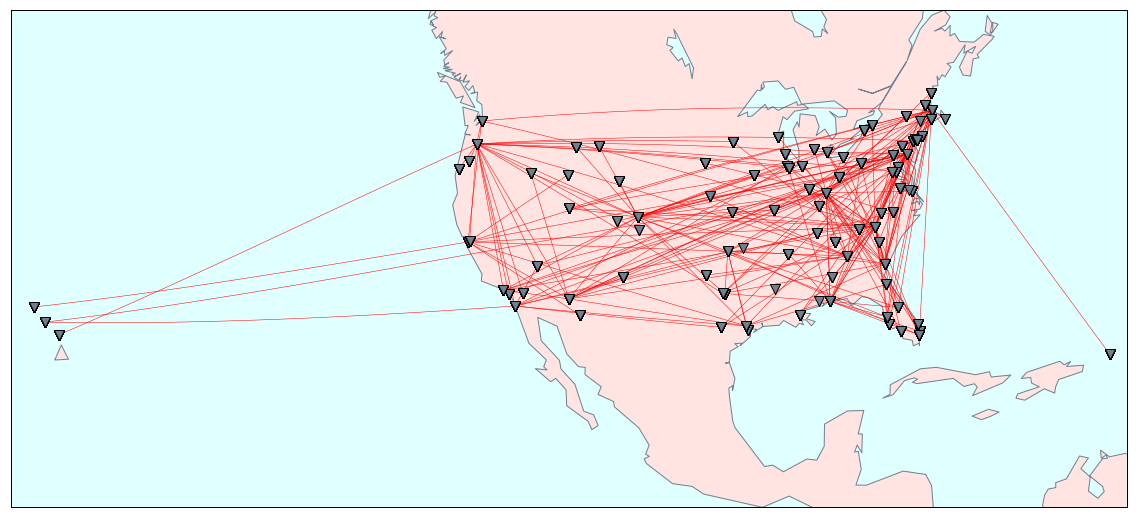

In [14]:
#map center
lat0 = np.mean(flights["Latitude"].astype(float))
lon0 = -112.0

fig = plt.figure(1, figsize=(20,20))
ax = fig.add_subplot(111)

#draw US map
m = Basemap(width=10100000,height=4500000,projection='lcc', resolution='c',lat_0=lat0, lon_0=lon0)
m.drawcoastlines(color="slategrey")
m.drawmapboundary(fill_color='lightcyan')
m.fillcontinents(color='mistyrose',lake_color='lightcyan')

#draw airport positions
airport_coordinates = {}
for index, row in flights.drop_duplicates(subset=["Departure_Airport"], keep='first', inplace=False).iterrows():
    airport_coordinates[row["Departure_Airport"]] = (row["Latitude"], row["Longitude"])
    
lons, lats = m(list(flights["Longitude"].astype(float)), list(flights["Latitude"].astype(float)))
m.scatter(lons, lats, s=100, marker='v', color="slategray", edgecolor='k', zorder=100, ax=ax)

#draw routes
routes = flights.drop_duplicates(subset=["Departure_Airport", "Arrival_airport"], keep="first")
for index, row in routes.iterrows():
    try:
        arr_airport = row["Arrival_airport"]

        dep_airport_lon = float(row["Longitude"])
        dep_airport_lat = float(row["Latitude"])

        arr_airport_lat = float(airport_coordinates[arr_airport][0])
        arr_airport_lon = float(airport_coordinates[arr_airport][1])

        m.drawgreatcircle(dep_airport_lon, dep_airport_lat,
                          arr_airport_lon, arr_airport_lat, linewidth=0.5, color='r')
    except:
        continue

By visualising the data, we have an insight on the dataset. Here are some observations:

- the most used airline is United Airlines (US) with more than 20k flight records;
- more than 4k flights landed in North Carolina (NC);
- but most of the flights depart from Texas and Georgia (TX and GA, respectively).

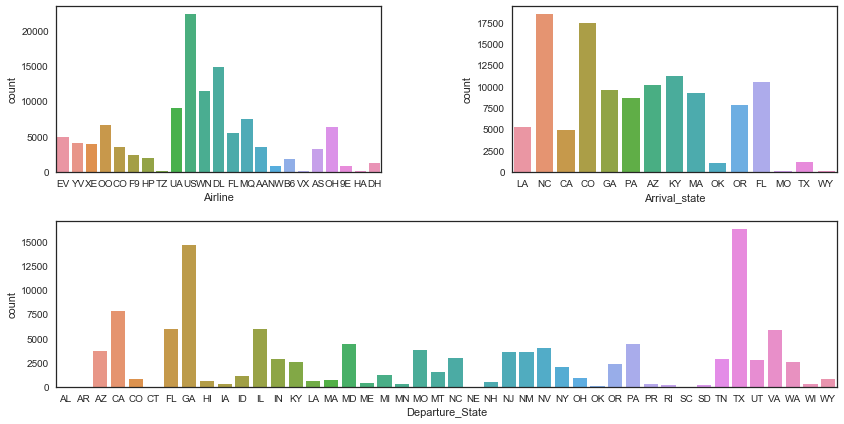

In [15]:
sns.set(font_scale=1)
sns.set_style("white")

f = plt.figure(2, figsize=(14,7))
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
ax1 = plt.subplot(grid[0,0])
ax2 = plt.subplot(grid[1,0:])
ax3 = plt.subplot(grid[0,1])

sns.countplot(x="Airline", data=flights, ax=ax1)
sns.countplot(x="Departure_State", data=flights, ax=ax2)
sns.countplot(x="Arrival_state", data=flights, ax=ax3)

- There is a constant number of flight throughout the year (~10k/month);
- whereas departure delay shows two peaks in June/July and December;
- flights landing in Arizona (AR) are in mean 40 minutes late.

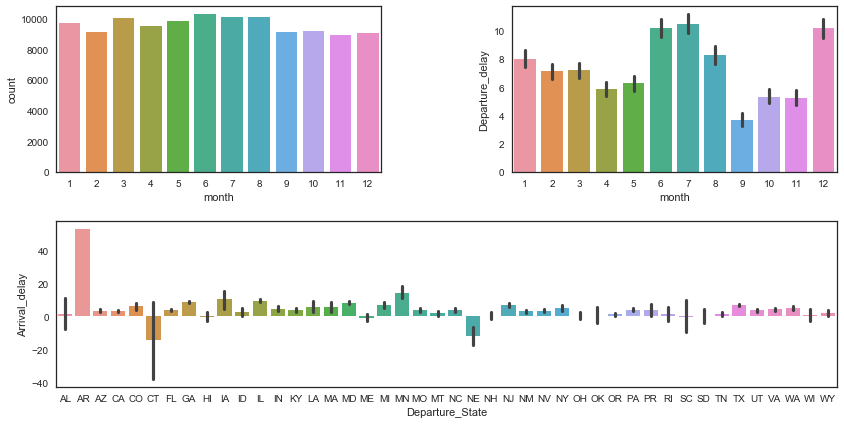

In [16]:
f = plt.figure(3, figsize=(14,7))
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
ax1 = plt.subplot(grid[0,0])
ax2 = plt.subplot(grid[0,1])
ax3 = plt.subplot(grid[1,0:])

sns.barplot(data=flights, x="month", y="Departure_delay", ax=ax2)
sns.countplot(data=flights, x="month", ax=ax1)
sns.barplot(x="Departure_State", y="Arrival_delay", data=flights, ax=ax3)

- The airline with the highest variability in departure delay is Virgin America (VX);
- whose delays are concentrate in March.

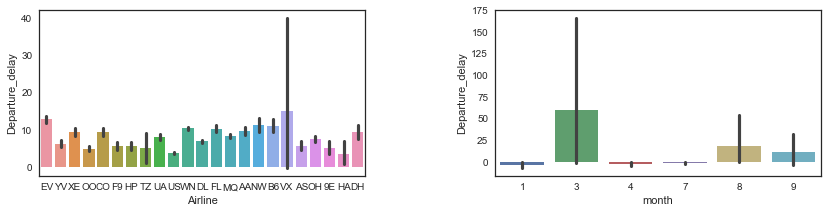

In [17]:
f = plt.figure(4, figsize=(14,7))
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
ax1 = plt.subplot(grid[0,0])
ax2 = plt.subplot(grid[0,1])

sns.barplot(data=flights, x="Airline", y="Departure_delay", ax=ax1)
sns.barplot(data=flights.loc[flights["Airline"] == "VX"],
            x="month", y="Departure_delay", ax=ax2)

- There are records of snow in the October to March period;
- April is the overall most windy month;
- while the hottest temperatures are in summer;
- the wind is stronger in the Hawaii island (HI) than in Arizona (AZ).

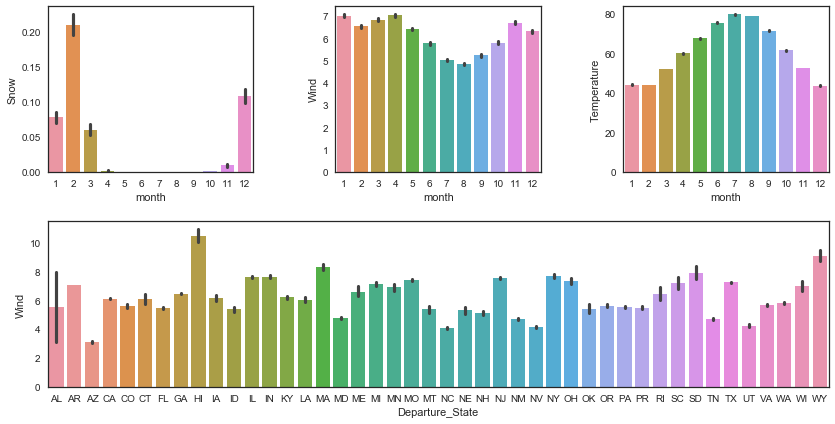

In [18]:
f = plt.figure(4, figsize=(14,7))
grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)
ax1 = plt.subplot(grid[0,0])
ax2 = plt.subplot(grid[0,1])
ax3 = plt.subplot(grid[0,2])
ax4 = plt.subplot(grid[1,0:])

sns.barplot(data=flights, x="month", y="Snow", ax=ax1)
sns.barplot(data=flights, x="month", y="Wind", ax=ax2)
sns.barplot(data=flights, x="month", y="Temperature", ax=ax3)
sns.barplot(data=flights, x="Departure_State", y="Wind", ax=ax4)

- Considering a threshold of 10 minutes, most of the flights in US were on time in the 10 years period analysed;
- however, the majority of flights from Hawaii (HI), Utah (UT), and Colorado (CO) were late;
- almost half of Delta Airlines flights were late.

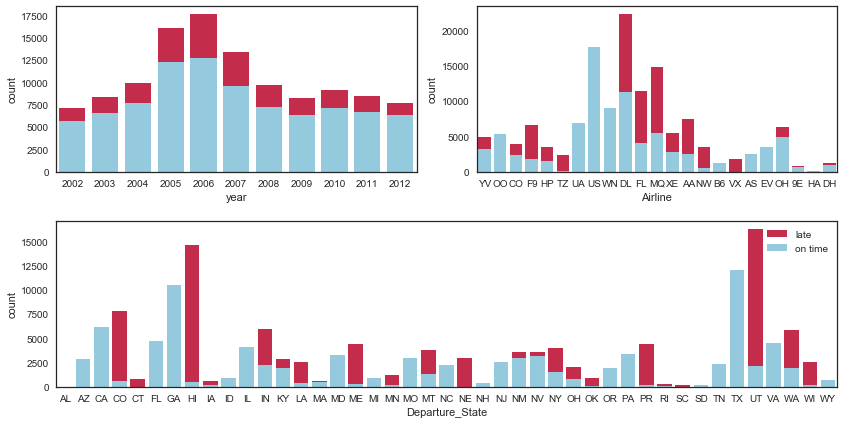

In [19]:
f = plt.figure(5, figsize=(14,7))
grid = plt.GridSpec(2, 4, wspace=0.4, hspace=0.3)
ax1 = plt.subplot(grid[0,0:2])
ax2 = plt.subplot(grid[0,2:])
ax4 = plt.subplot(grid[1,0:])

sns.countplot(data=flights, x="year", color="crimson", label="late", ax=ax1)
sns.countplot(data=flights.loc[flights["Arrival_delay"] <= 10.0], x="year",
              color="skyblue", label="on time", ax=ax1)

sns.countplot(data=flights, x="Airline", color="crimson", label="late", ax=ax2)
sns.countplot(data=flights.loc[flights["Arrival_delay"] <= 10.0], x="Airline",
              color="skyblue", label="on time", ax=ax2)

sns.countplot(data=flights, x="Departure_State", color="crimson", label="late", ax=ax4)
sns.countplot(data=flights.loc[flights["Arrival_delay"] <= 10.0], x="Departure_State",
              color="skyblue", label="on time", ax=ax4)
plt.legend()

- The route with most delays for Delta Airlines is the one connecting Georgia (GA) to Florida (FL).

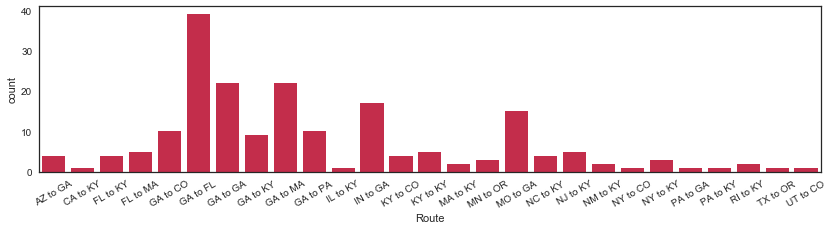

In [20]:
f = plt.figure(6, figsize=(14,7))
grid = plt.GridSpec(2, 4, wspace=0.4, hspace=0.3)
ax1 = plt.subplot(grid[0,0:])

sns.countplot(data=flights.loc[flights["Airline"] == "DL"].loc[flights["Arrival_delay"] >= 120],
              x="Route", color="crimson", label="late", ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30);
